Mild: 0.0005 + 0.004 * dfc["ballpark_mysticism"] (ALL SEASONS)

Haunted: 0.2 (Season 12) More to come, likely a logging error

Electric: 0.05 + 0.1 * dfc["ballpark_mysticism"] (SEASON 12-15)
          0.0325 + 0.1 * dfc["ballpark_mysticism"] or 0.033 + 0.1 * dfc["ballpark_mysticism"] (SEASON 16)
          0.025 + 0.1*dfc["ballpark_mysticism"] (SEASON 17)
          0.02085 + 0.1*dfc["ballpark_mysticism"] (SEASON 18)

Peanut Mister: 0.0005 (ALL SEASONS. NOTE: IF NO ELIGIBLE TARGETS THEN NO TARGET ROLL)

Smithy: 0.0004 (ALL SEASONS)

Taste the Infinite (Pitcher): 0.001 (ALL SEASONS)

Birds Ambush: 0.0255 (ALL SEASONS)

Charm: 0.015 + 0.02*dfc["ballpark_mysticism"] (SEASON 12-17)  
       0.014 + 0.006*dfc["ballpark_mysticism"] (SEASON 18)

Echo Chamber: 0.0055 (SEASON 14-17)
              0.013 (SEASON 18)
              Between 0.006 & 0.012 (SEASON 19)

Base Intincts: 0.2 (ALL SEASONS)


Debt_Three: 0.0095 (ALL SEASONS FOR ACTUAL REAL DEBT)
            0.015 (ALL SEASONS BUT FOR COPIED DEBT)
            (THIS IS LIKELY CAUSED BY A STAT BUT IT'S HARD TO TELL WITH LIMITED DATA AND CHORBY SHELLING SOUL WITH FLOORED STATS)

Psychic (Pitcher): 0.075ish
Psychic (Batter): 0.078 + 0.0375*dfc["ballpark_mysticism"]

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

import load

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [2]:
seasons = [14,15,16,17,18]
df = load.data("modproc", season=seasons)

len(df)

932608

In [31]:
df["ruth_vibes"] = load.player_attribute(
    # These values are mandatory: the dataframe, the player role, and the attribute
    df, 'pitcher', 'ruthlessness',
    # These are all optional, and the default values are as they appear here
    vibes=True, mods=True, items=True, broken_items=True
)
df["cold_vibes"] = load.player_attribute(df, 'pitcher', 'coldness', vibes=True, mods=True, items=True, broken_items=True)
df["opw_vibes"] = load.player_attribute(df, 'pitcher', 'overpowerment', vibes=True, mods=True, items=True, broken_items=True)
df["shakes_vibes"] = load.player_attribute(df, 'pitcher', 'shakespeareanism', vibes=True, mods=True, items=True, broken_items=True)
df["supp_vibes"] = load.player_attribute(df, 'pitcher', 'suppression', vibes=True, mods=True, items=True, broken_items=True)
df["unthwack_vibes"] = load.player_attribute(df, 'pitcher', 'unthwackability', vibes=True, mods=True, items=True, broken_items=True)

df["forwardness"] = load.stadium_attribute(df, 'forwardness', center=False)
df["mysticism"] = load.stadium_attribute(df, 'mysticism', center=False)
df["fortification"] = load.stadium_attribute(df, 'fortification', center=False)
df["obtuseness"] = load.stadium_attribute(df, 'obtuseness', center=False)
df["grandiosity"] = load.stadium_attribute(df, 'grandiosity', center=False)
df["ominousness"] = load.stadium_attribute(df, 'ominousness', center=False)
df["inconvenience"] = load.stadium_attribute(df, 'inconvenience', center=False)
df["viscosity"] = load.stadium_attribute(df, 'viscosity', center=False)
df["elongation"] = load.stadium_attribute(df, 'elongation', center=False)
df["filthiness"] = load.stadium_attribute(df, 'filthiness', center=False)

In [32]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]

len(dfc)

932608

In [33]:
mister_events = ("cure", "NoCure")
mild_events = ("Mild", "NoMild")
birds_ambush_events = ("Ambushed", "NoBush")
echo_chamber_events = ("Copy", "nocopy")
taste_infinite_events = ("shelled2", "no shell2")
electric_events = ("Zap", "NoZap")
base_instinct_events = ("Walk", "Balk", "Second", "Third")
smithy_events = ("Fix", "NoFix")
haunted_events = ("NoHaunt", "YesHaunt")
grind_rail_events = ("Grind", "NoGrind")
taste_infinite_batter_events = ("shelled1", "no shell1")
debt_events = ("Bonk", "No Bonk")
big_buckets_events = ("Bucket", "NoBucket")
acidic_events = ("Acidic Pitch", "Not Acidic Pitch")
double_strike_events = ("Double Strike", "Single Strike")
hotel_motel_events = ("Hotel", "Notel")

include_events = hotel_motel_events

dfc = dfc[dfc["event_type"].astype(str).isin(include_events)]

len(dfc)

4613

In [58]:
X = dfc[
    [
        "roll",
        "passed",
        #"mysticism",
        #"grandiosity",
        #"viscosity",
        #"unthwack_vibes",
        #"ruth_vibes",
        #"cold_vibes",
        #"opw_vibes",
        #"supp_vibes",
        #"shakes_vibes",

    ]
].copy()
#X = X[X["pitcher_musclitude"] > 0.07]

y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = 0.01
pins = [
    #(-0.0025, "mysticism"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[4566    3]
 [   2   42]]
5 outliers
0.9989161066551051
0.01


[(1.0, 'roll'), (6.136162484415919e-05, 'season')]

In [35]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

4569
44


In [49]:
dfc["threshold"] = 0.01

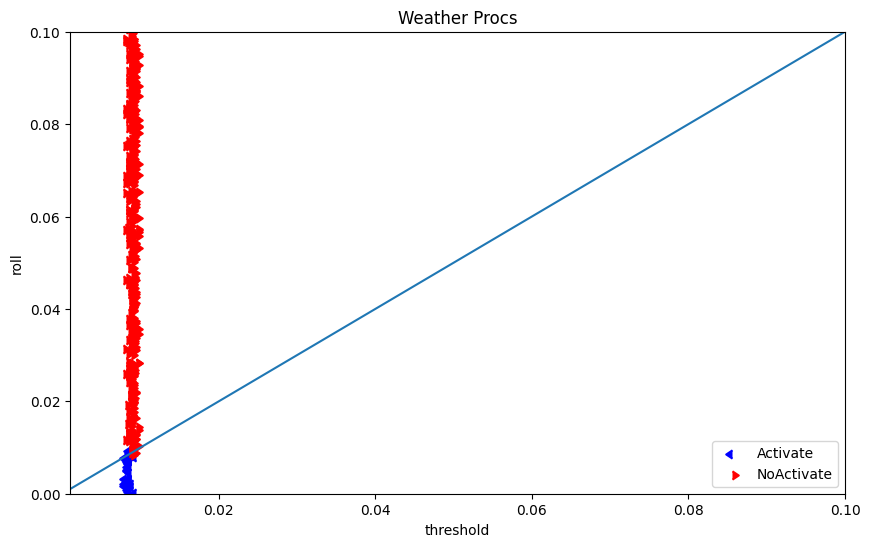

In [28]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Activate", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoActivate", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Weather Procs")
ax.set_xlim([0.001, 0.1])
ax.set_ylim([0.0, 0.1])
ax.legend()

,offset,event_type,season,roll,threshold,mysticism,batter_name,pitcher_name,batter_mods,pitcher_mods,season,day,game_id,play_count
666076,-0.001542,Notel,18,0.008458,0.01,0.481923,Null Player,Uncle Plasma,,EGO1;HARD_BOILED,18,16,956b286d-48cd-4b01-9699-651b305306ac,161
629458,-0.001177,Notel,18,0.008823,0.01,0.377057,Null Player,Uncle Plasma,,EGO1;HARD_BOILED,18,4,80ab0a82-05bd-47ee-aa1b-67bd626c3ece,278
670406,-0.001105,Notel,18,0.008895,0.01,0.590713,Null Player,Penelope Mathews,,FRIEND_OF_CROWS,18,18,f050925c-3f5e-494c-a7dc-c55ed98d2362,29
667537,-0.001084,Notel,18,0.008916,0.01,0.438299,Null Player,Michelle Sportsman,,CAREFUL,18,17,0ec8e756-8afa-4182-82de-364e6f355688,2
692987,-0.000613,Notel,18,0.009387,0.01,0.588595,Null Player,Cravel Gesundheit,,,18,25,e77a29f4-658b-479b-9dbe-e604f5b64b15,3
621040,-0.000338,Notel,18,0.009662,0.01,0.506594,Null Player,Jayden Wright,,,18,2,ab2b13b9-2ec5-48e5-9b65-5e66bb26f59f,3


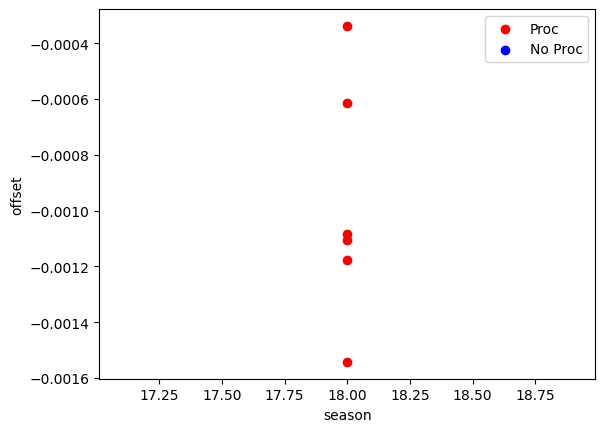

In [57]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
#outliers = outliers[outliers["pitcher_musclitude"] > 0.07]
fig, ax = plt.subplots(1)
x_val = "season"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Proc")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="No Proc")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type", "season",
       "roll", "threshold", "mysticism",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "season", "day",  "game_id", "play_count"]].sort_values('offset')


In [62]:
print(dfc[dfc["passed"] & (dfc["season"] > 18)]["roll"].max())
print(dfc[~dfc["passed"] & (dfc["season"] > 18)]["roll"].min())

nan
nan
